# Clean SWED dataset

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from osgeo import gdal

import os
import glob
import random

from swed_utils import *

In [34]:

checked = open("checked.txt", "r")
checked_names = checked.read().splitlines()
checked_paths = ["../../data/SWED/train/images/{}".format(name) for name in checked_names]
checked.close()

print(checked_paths[0])
print(len(checked_paths))

../../data/SWED/train/images/S2A_MSIL2A_20190427T065631_N0211_R063_T39PVL_20190427T101053_image_8_6.npy
10779


In [35]:
# Load input paths
paths = glob.glob("../../data/SWED/train/images/*")

# remove paths in checked.txt
paths = [path for path in paths if path not in checked_paths]

print(paths[0])
print(len(paths))

../../data/SWED/train/images/S2B_MSIL2A_20200207T113309_N0214_R080_T28PCA_20200207T132518_image_18_26.npy
17445


## Step 1: Missing data

In [36]:
def check_img(path):
    """Check if image is all zeros"""

    img = np.load(path)
    test = (np.max(img) + np.min(img) != 0)
    
    return test

# Get paths with missing data
missing_data = [path for path in paths if not check_img(path)]

print(len(missing_data))

2430


../../data/SWED/train/images/S2A_MSIL2A_20191128T144731_N0213_R139_T20PLS_20191128T171514_image_20_1.npy


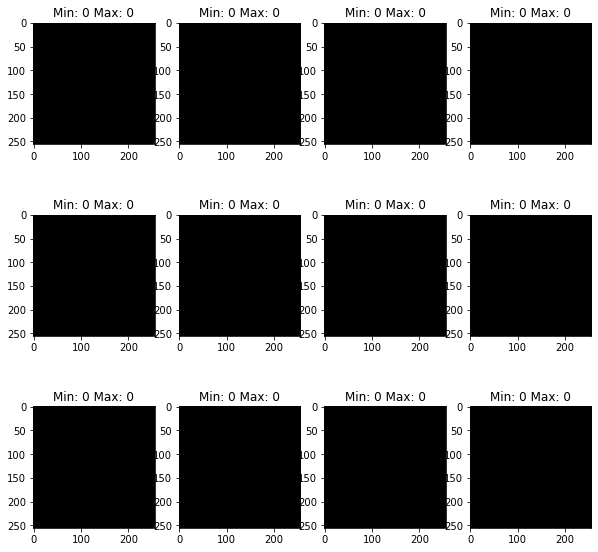

In [11]:
# Plot a random image with missing data
rint = random.randint(0,len(missing_data))

# Get path
path = missing_data[rint]
print(path)

# Load image
img = np.load(path)

# display all bands
fig, ax = plt.subplots(3,4,figsize=(10,10))
index = 0 
for i in range(3):
    for j in range(4):
        
        band = img[:,:,index]
        min_band = np.min(band)
        max_band = np.max(band)

        ax[i,j].imshow(band,cmap='gray')
        ax[i,j].set_title("Min: {} Max: {}".format(min_band,max_band))
        index += 1

In [ ]:
28224 - 2430 - 66

In [4]:
#Save names of images with missing data
missing_data_names = [path.split("/")[-1] for path in missing_data]

# Save names of images with missing data    
with open("missing_data.txt", "w") as f:
    for name in missing_data_names:
        f.write(name + "\n")

NameError: name 'missing_data' is not defined

## Step 2: All land masks 


In [47]:
def check_mask(path):
    """Check if mask is all zeros"""

    mask_path = path.replace("images","labels").replace("image","chip")
    mask = np.load(mask_path)

    test = (np.max(mask) ==1) & (np.min(mask) ==0)
    
    return test

# Get paths where mask is all zeros
masks_0 = [path for path in paths if check_mask(path)]
print(len(masks_0))

# Remove paths with missing data
masks_0 = [path for path in masks_0 if path not in missing_data]
print(len(masks_0))

8851
8851


In [31]:
# Repeate process for unclear images
masks_0 = open("unclear.txt", "r").read().splitlines()
checked = open("checked.txt", "r").read().splitlines() #paths of images that have been checked
remove = open("remove.txt", "r").read().splitlines() #paths of images that should be removed
incorrect = open("incorrect.txt", "r").read().splitlines() #paths of images that should be removed

masks_0 = [path for path in masks_0 if path not in checked]
masks_0 = [path for path in masks_0 if path not in remove]
masks_0 = [path for path in masks_0 if path not in incorrect]


masks_0 = ["../../data/SWED/train/images/{}".format(name) for name in masks_0]
print(len(masks_0))

313


In [55]:
# Plot a random image with all zeros mask
rint = random.randint(0,len(masks_0))

# Get path
path = masks_0[rint]
print(path)

plot_label(path)

../../data/SWED/train/images/S2A_MSIL2A_20191222T125301_N0213_R052_T24MXV_20191222T144240_image_16_38.npy


In [33]:
def get_rgb2(img):
    """Return normalized RGB channels from sentinal image"""
    
    rgb_img = img[:, :, [3,2,1]]
    rgb_1 = np.clip(rgb_img/10000, 0, 0.4)/0.4
    rgb_2 = np.clip(rgb_img/10000, 0, 0.3)/0.3

    rgb_3 = np.clip(rgb_img/10000, 0, 0.2)/0.2
    rgb_4 = np.clip(rgb_img/10000, 0, 0.1)/0.1
    
    return rgb_1,rgb_2,rgb_3,rgb_4


def onpress(event):
    global img_path 
    global incorrect
    global unclear
    #global checked
    global remove
    
    #Get key 
    key = event.key
    
    #Get image name
    path = img_path[0]
    
    if key not in ["w","l","x"]:
        print("Invalid Key")
    else: 
        checked.append(path)
        
        if key == "w":
            incorrect.append(path)
            print("WATER: " + path)
            
        elif key == "x":
            remove.append(path)
            #unclear.append("UNCLEAR: " + path)
        
        # Clear plot 
        plt.close('all')

        if len(img_path) > 0: 
            
            img_path = img_path[1:]
            path = img_path[0]
            img, rgb_img, label = load_train(path)
            rgb1, rgb2, rgb3, rgb4 = get_rgb2(img)
      
            min_label = np.min(label)
            max_label = np.max(label)

            fig,axs = plt.subplots(2,2,figsize=(15,15))
            fig.canvas.mpl_connect('key_press_event', onpress)

            #Load first image and add count
            axs[0,0].imshow(rgb1)
            axs[0,0].text(0, 15, len(img_path),color='r',size=20)
            axs[0,1].imshow(rgb2)
            axs[1,0].imshow(rgb3)
            axs[1,1].imshow(rgb4)


            """axs[1,1].imshow(label,cmap="BrBG")
            axs[1,1].set_title("Min: {} Max: {}".format(min_label,max_label))
            axs[1,1].text(0, 15, len(img_path),color='r',size=20)"""

            
            plt.show()

In [34]:
%matplotlib tk
global img_path 
global incorrect
global unclear
global checked
global remove


incorrect  = open("incorrect.txt", "r").read().splitlines() #paths of images with incorrect labels 
unclear = open("unclear.txt", "r").read().splitlines() #paths of images where it is unclear whihc is the correct label
checked = open("checked.txt", "r").read().splitlines() #paths of images that have been checked
remove = open("remove.txt", "r").read().splitlines() #paths of images that should be removed

#Get all image paths with all zeros mask
img_path = masks_0

path = img_path[0]
img, rgb_img, label = load_train(path)
rgb1, rgb2, rgb3,rgb4 = get_rgb2(img)

#min_label = np.min(label)
#max_label = np.max(label)

#Load first image and add count
fig,axs = plt.subplots(2,2,figsize=(15,15))


axs[0,0].imshow(rgb1)
axs[0,1].imshow(rgb2)
axs[1,0].imshow(rgb3)
axs[1,1].imshow(rgb4)

"""axs[1,1].imshow(label,cmap="BrBG")
axs[1,1].set_title("Min: {} Max: {}".format(min_label,max_label))
axs[1,1].text(0, 15, len(img_path),color='r',size=20)"""

#Add an interactive widget to figure 
fig.canvas.mpl_connect('key_press_event', onpress)

plt.show()

WATER: ../../data/SWED/train/images/S2A_MSIL2A_20180607T104021_N0208_R008_T31UFV_20180607T132721_image_31_30.npy
WATER: ../../data/SWED/train/images/S2A_MSIL2A_20180607T104021_N0208_R008_T31UFV_20180607T132721_image_23_27.npy
WATER: ../../data/SWED/train/images/S2A_MSIL2A_20180607T104021_N0208_R008_T31UFV_20180607T132721_image_15_40.npy
WATER: ../../data/SWED/train/images/S2A_MSIL2A_20180607T104021_N0208_R008_T31UFV_20180607T132721_image_27_25.npy
WATER: ../../data/SWED/train/images/S2A_MSIL2A_20180607T104021_N0208_R008_T31UFV_20180607T132721_image_23_40.npy
WATER: ../../data/SWED/train/images/S2A_MSIL2A_20180607T104021_N0208_R008_T31UFV_20180607T132721_image_11_31.npy
WATER: ../../data/SWED/train/images/S2A_MSIL2A_20180607T104021_N0208_R008_T31UFV_20180607T132721_image_18_29.npy
WATER: ../../data/SWED/train/images/S2A_MSIL2A_20180607T104021_N0208_R008_T31UFV_20180607T132721_image_27_24.npy
WATER: ../../data/SWED/train/images/S2A_MSIL2A_20180607T104021_N0208_R008_T31UFV_20180607T132721

Traceback (most recent call last):
  File "/Users/conorosullivan/opt/miniconda3/envs/pytorch/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_18510/3306350094.py", line 46, in onpress
    path = img_path[0]
IndexError: list index out of range


In [35]:
#Save names of images incorrectly labelled as land
incorrect_names = [path.split("/")[-1] for path in incorrect]

with open("incorrect.txt", "w") as f:
    for name in incorrect_names:
        f.write(name + "\n")

"""#Save names of images where it is unclear which is the correct label
unclear_names = [path.split("/")[-1] for path in unclear]

with open("unclear.txt", "w") as f:
    for name in unclear_names:
        f.write(name + "\n")"""

#Save names of images that have been checked
checked_names = [path.split("/")[-1] for path in checked]

with open("checked.txt", "w") as f:
    for name in checked_names:
        f.write(name + "\n")

remove_names = [path.split("/")[-1] for path in remove]

with open("remove.txt", "w") as f:
    for name in remove_names:
        f.write(name + "\n")

print(len(incorrect),len(remove),len(checked))

518 65 603


In [ ]:
#Recheck


#remove
S2A_MSIL2A_20180607T104021_N0208_R008_T31UFV_20180607T132721_image_19_24.npy



#Water



In [38]:
plot_label("../../data/SWED/train/images/S2A_MSIL2A_20190718T230911_N0213_R101_T58KDB_20190719T005046_image_26_29.npy")